### EMOVOICE: Real-time Speech Emotion Recognition Using Raw Audio Features and Deep Learning

### Importing Data

In [1]:
%pip install kagglehub librosa numpy noisereduce evaluate transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 136.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 115.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import kagglehub
import torchaudio as ta
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import torch as t
from torch import nn
import numpy as np
import librosa
import noisereduce as nr
from typing import Optional, Callable

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


In [22]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Wav2Vec2‑base on RAVDESS with AMP, lr = 3e‑5,
freeze encoder epoch 0, unfreeze top‑4 layers afterwards.
"""

# ----------------------- CONFIG -----------------------
DATA_DIR   = path
EXP_DIR    = "./exp_ravdess_amp"
SR         = 16_000
SEED       = 40

NUM_EPOCHS = 3
TRAIN_BS   = 4                   # GPU batch
EVAL_BS    = 4
GRAD_ACCUM = 2                   # 4×2 ⇒ eff 8
LR         = 3e-5

# ----------------------- IMPORTS ----------------------
import os, re, random
from pathlib import Path
import torch, torchaudio
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataclasses import dataclass
from tqdm.auto import tqdm

torch.manual_seed(SEED); random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(EXP_DIR, exist_ok=True)

# ----------------------- DATASET ----------------------
EMO_RE = re.compile(r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-"
                    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\.wav")

def emotion_id(name: str) -> int:
    return int(EMO_RE.search(name).group(3)) - 1          # 0‑7

def load_audio(path: Path):
    wav, sr = torchaudio.load(path)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.mean(dim=0) / (wav.abs().max() + 1e-9)
    return wav.clamp_(-0.99, 0.99)

class RAVDESS(Dataset):
    def __init__(self, paths): self.paths = paths
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        return {"wav": load_audio(p), "label": emotion_id(p.name)}

all_files = sorted(Path(DATA_DIR).rglob("*.wav"))
train_p, val_p = train_test_split(
    all_files, test_size=0.2,
    stratify=[emotion_id(p.name) for p in all_files],
    random_state=SEED,
)

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

@dataclass
class Collate:
    def __call__(self, batch):
        audio  = [b["wav"].cpu().numpy() for b in batch]
        labels = torch.tensor([b["label"] for b in batch])
        proc   = processor(audio, sampling_rate=SR,
                           padding=True, return_tensors="pt")
        proc["labels"] = labels
        return proc

train_ld = DataLoader(RAVDESS(train_p), TRAIN_BS, True,
                      collate_fn=Collate(), pin_memory=True)
val_ld   = DataLoader(RAVDESS(val_p),   EVAL_BS, False,
                      collate_fn=Collate(), pin_memory=True)

# ----------------------- MODEL ------------------------
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=8,
).to(device)
model.gradient_checkpointing_enable()
model.freeze_feature_encoder()       # frozen for epoch 0

# -------------------- OPT & SCHED ---------------------
optimizer = AdamW(model.parameters(), lr=LR,
                  betas=(0.9, 0.98), eps=1e-6, weight_decay=0.01)

total_steps = (len(train_ld) // GRAD_ACCUM) * NUM_EPOCHS
warm_steps  = int(0.1 * total_steps)
scheduler   = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warm_steps,
    num_training_steps=total_steps,
)

# ---------------- ENABLE AMP --------------------------
scaler = torch.cuda.amp.GradScaler()

# -------------- TRAIN / VALIDATE ----------------------
def evaluate():
    model.eval(); preds, gts = [], []
    with torch.no_grad():
        for batch in val_ld:
            batch = {k:v.to(device) for k,v in batch.items()}
            logits = model(**batch).logits
            preds.extend(logits.argmax(-1).cpu())
            gts.extend(batch["labels"].cpu())
    return accuracy_score(gts, preds)

step_global = 0
train_loss_history   = []   # step‑level
val_acc_history      = []   # epoch‑level
best_acc             = 0.0
for epoch in range(1, NUM_EPOCHS + 1):

    # # --------- unfreeze top‑4 layers after epoch 0 ----------
    # if epoch == 2:
    #     for layer in model.wav2vec2.encoder.layer[-4:]:
    #         for p in layer.parameters():
    #             p.requires_grad = True
    #     print("Unfroze top‑4 encoder layers.")

    model.train()
    pbar = tqdm(train_ld, desc=f"Epoch {epoch}/{NUM_EPOCHS}", ncols=0)
    optimizer.zero_grad(set_to_none=True)

    for step_local, batch in enumerate(pbar, 1):
        batch = {k:v.to(device) for k,v in batch.items()}

        with torch.cuda.amp.autocast():
            loss = model(**batch).loss / GRAD_ACCUM

        scaler.scale(loss).backward()

        if step_local % GRAD_ACCUM == 0:
            train_loss_history.append(loss.item() * GRAD_ACCUM)
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)
            step_global += 1

        pbar.set_postfix(loss=f"{loss.item()*GRAD_ACCUM:.4f}",
                         lr=scheduler.get_last_lr()[0])

    acc = evaluate()
    print(f"→ Validation accuracy after epoch {epoch}: {acc:.4f}")
    val_acc_history.append(acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(),"best_model.pt")

print(f"\n*** Final accuracy after {NUM_EPOCHS} epochs: {acc:.4f} ***")


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-22-9c757d431334>:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/3:   0% 0/576 [00:00<?, ?it/s]

<ipython-input-22-9c757d431334>:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


→ Validation accuracy after epoch 1: 0.7934


Epoch 2/3:   0% 0/576 [00:00<?, ?it/s]

<ipython-input-22-9c757d431334>:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


→ Validation accuracy after epoch 2: 0.8733


Epoch 3/3:   0% 0/576 [00:00<?, ?it/s]

<ipython-input-22-9c757d431334>:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


→ Validation accuracy after epoch 3: 0.9080

*** Final accuracy after 3 epochs: 0.9080 ***


In [ ]:
OUTPUT_DIR = "./exp_ravdess_amp/best_ckpt"     # pick any folder name
os.makedirs(OUTPUT_DIR, exist_ok=True)

model.save_pretrained(OUTPUT_DIR)             # ⇦ weights + config
processor.save_pretrained(OUTPUT_DIR)         # ⇦ tokenizer / feature extractor

[]

In [ ]:
class SpeechDataset(Dataset):
    def __init__(self, root_dir, transform=None, segment_length=1000):
        self.root_dir = root_dir
        self.transform = transform
        self.segment_length = segment_length

        self.filelist = []
        for root, dirs, files in os.walk(self.root_dir):
            for name in files:
                self.filelist.append(os.path.join(root, name))
        self.filelist = np.array(self.filelist)


    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        if t.is_tensor(idx):
            idx = idx.tolist()

        path = os.path.join(self.root_dir, self.filelist[idx])

        label = os.path.basename(path)
        mod, chan, emo, inten, state, repit, act = str(label).split("-")

        audio, rate = ta.load(path)
        emotion = int(emo)-1

        num_samples = int(self.segment_length * rate)
        if audio.shape[1] > num_samples:
            # Random crop for training
            start = np.random.randint(0, audio.shape[1] - num_samples)
            audio = audio[:, start:start+num_samples]
        elif audio.shape[1] < num_samples:
            # Pad with zeros if too short
            padding = num_samples - audio.shape[1]
            audio = t.nn.functional.pad(audio, (0, padding))

        # Apply the transform (Pipeline) here
        if self.transform:
            audio = self.transform(audio)

        return {"input_values": audio, "label": emotion}

# Then, when creating the dataset:


In [ ]:
from transformers import AutoFeatureExtractor

class Pipeline(nn.Module):
    def __init__(self, input_rate, noise_reduce=True, normalize=True):
        super().__init__()
        self.noise_reduce = noise_reduce
        self.input_rate = input_rate
        # self.feature_extractor = AutoFeatureExtractor.from_pretrained("../Wave2Vec", do_normalize=normalize)
        self.feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h", do_normalize=normalize)

        if self.input_rate != self.feature_extractor.sampling_rate:
            self.resampler = T.Resample(self.input_rate,  self.feature_extractor.sampling_rate)
        else:
            self.resampler = None


    def forward(self, waveform):
        if self.resampler:
            waveform = self.resampler(waveform)

        if waveform.shape[0] > 1:
            waveform = t.mean(waveform, dim=0, keepdim=True)

        if self.noise_reduce:
            waveform_np = waveform.numpy()[0]
            reduced_noise = nr.reduce_noise(
                y=waveform_np,
                sr=self.input_rate,
                stationary=True
            )
            waveform = t.from_numpy(reduced_noise).unsqueeze(0)


        waveform = self.feature_extractor(
        waveform, sampling_rate=self.feature_extractor.sampling_rate, return_tensors="pt"
        )["input_values"].squeeze()

        return waveform

In [ ]:
Data = SpeechDataset(path, transform=pipe, segment_length=2) # Pass the pipe instance
trainset, testset = t.utils.data.random_split(Data, [0.85, 0.15])

### Training

In [ ]:
trainloader = t.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testloader = t.utils.data.DataLoader(testset, batch_size=4, shuffle=True)



In [ ]:
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate

device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(device)

# model = AutoModelForAudioClassification.from_pretrained("../Wave2Vec", num_labels=8).to(device)
model = AutoModelForAudioClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=8).to(device)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=pipe.feature_extractor, padding="longest")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    acc = (preds == labels).astype(np.float32).mean().item()
    return {"accuracy": acc}


# accuracy = evaluate.load("accuracy")
# def compute_metrics(eval_pred):
#     predictions = np.argmax(eval_pred.predictions, axis=1)
#     return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

training_args = TrainingArguments(
    output_dir="model_data",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate= 0.0001,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    fp16=True,
    lr_scheduler_type="cosine"  # Add scheduler
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset,
    eval_dataset=testset,
    compute_metrics=compute_metrics,
)

trainer.evaluate()
trainer.train()
trainer.evaluate()

KeyboardInterrupt: 

In [ ]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(3):
    for batch in trainloader:
        if batch is None:
            continue
        inputs = data_collator({"input_values": batch["input_values"]})["input_values"].to(device)
        labels = torch.tensor(batch["label"]).to(device)
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        grad_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)
        print(f"Epoch {epoch+1}, Grad Norm: {grad_norm}")
        optimizer.step()
        optimizer.zero_grad()

<ipython-input-40-475cd7ddc272>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["label"]).to(device)


Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan
Epoch 1, Grad Norm: nan


KeyboardInterrupt: 

In [ ]:
model.train()
for batch in trainloader:
    if batch is None:
        continue
    collated_batch = data_collator(batch)
    inputs = collated_batch["input_values"].to(device)
    labels = collated_batch["labels"].to(device)
    attention_mask = collated_batch.get("attention_mask", None)  # Handle optional attention_mask
    print("Inputs shape:", inputs.shape)
    print("Input values min/max:", inputs.min().item(), inputs.max().item())
    print("Any NaN in inputs:", torch.isnan(inputs).any().item())
    print("Any Inf in inputs:", torch.isinf(inputs).any().item())
    if attention_mask is not None:
        attention_mask = attention_mask.to(device)
        outputs = model(inputs, labels=labels, attention_mask=attention_mask)
    else:
        outputs = model(inputs, labels=labels)
    loss = outputs.loss
    print("Computed loss:", loss.item() if torch.isfinite(loss) else "nan")
    loss.backward()
    grad_norms = [p.grad.norm() for p in model.parameters() if p.grad is not None]
    grad_norm = sum(gn.item() for gn in grad_norms if torch.isfinite(gn)) if grad_norms else float('nan')
    print("Gradient norm:", grad_norm if torch.isfinite(torch.tensor(grad_norm)) else "nan")
    break

Inputs shape: torch.Size([4, 32000])
Input values min/max: -11.443321228027344 11.298056602478027
Any NaN in inputs: False
Any Inf in inputs: False
Computed loss: nan
Gradient norm: 0


### Visualizing

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

KeyError: 'waveform'

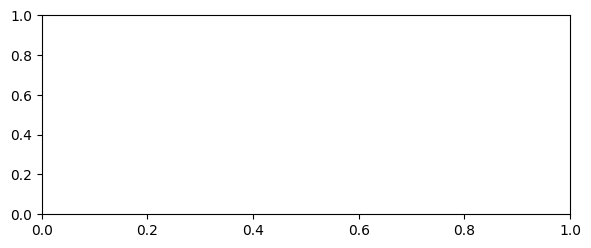

In [ ]:
def visualize_samples(dataset, num_samples=5):
    """Visualize random audio samples and their spectrograms"""
    indices = np.random.choice(len(dataset), num_samples)
    emotion_map = {
        0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad',
        4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'
    }

    plt.figure(figsize=(15, 3*num_samples))
    for i, idx in enumerate(indices):
        sample = dataset[idx]

        # Plot waveform
        plt.subplot(num_samples, 2, 2*i+1)
        plt.plot(sample['waveform'].squeeze().numpy())
        plt.title(f"Waveform - Emotion: {emotion_map[sample['emotion'].item()]}")
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

        # Plot spectrogram
        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(sample['spectrogram'].squeeze().numpy(),
                  aspect='auto', origin='lower')
        plt.title("Mel Spectrogram")
        plt.colorbar()
        plt.xlabel('Time frames')
        plt.ylabel('Frequency bins')

    plt.tight_layout()
    plt.show()

visualize_samples(Data)

In [ ]:
def plot_emotion_distribution(dataloader):
    """Plot histogram of emotion labels in the dataset"""
    all_emotions = []
    for batch in dataloader:
        all_emotions.extend(batch['emotion'].tolist())

    emotion_map = {
        0: 'neutral', 1: 'calm', 2: 'happy', 3: 'sad',
        4: 'angry', 5: 'fearful', 6: 'disgust', 7: 'surprised'
    }

    plt.figure(figsize=(10, 5))
    sns.countplot(x=all_emotions)
    plt.xticks(ticks=range(8), labels=[emotion_map[i] for i in range(8)], rotation=45)
    plt.title('Emotion Class Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()

plot_emotion_distribution(Data)

KeyError: 'emotion'

In [ ]:
def compare_augmentations(dataset, idx=0):
    """Compare original and augmented samples"""
    original = dataset[idx]
    augmented = dataset[idx]  # apply transform if defined

    plt.figure(figsize=(12, 6))

    # Original waveform
    plt.subplot(2, 2, 1)
    plt.plot(original['waveform'].squeeze().numpy())
    plt.title('Original Waveform')

    # Original spectrogram
    plt.subplot(2, 2, 2)
    plt.imshow(original['spectrogram'].squeeze().numpy(),
              aspect='auto', origin='lower')
    plt.title('Original Spectrogram')

    # Augmented waveform
    plt.subplot(2, 2, 3)
    plt.plot(augmented['waveform'].squeeze().numpy())
    plt.title('Augmented Waveform')

    # Augmented spectrogram
    plt.subplot(2, 2, 4)
    plt.imshow(augmented['spectrogram'].squeeze().numpy(),
              aspect='auto', origin='lower')
    plt.title('Augmented Spectrogram')

    plt.tight_layout()
    plt.show()

# after add transforms

# compare_augmentations(dataset)

In [ ]:
def calculate_batch_stats(dataloader):
    """Calculate mean and std of waveforms and spectrograms"""
    waveform_sum = 0
    waveform_sq_sum = 0
    spectrogram_sum = 0
    spectrogram_sq_sum = 0
    total_samples = 0

    for batch in dataloader:
        waveforms = batch['waveform']
        spectrograms = batch['spectrogram']

        waveform_sum += waveforms.sum()
        waveform_sq_sum += (waveforms**2).sum()

        spectrogram_sum += spectrograms.sum()
        spectrogram_sq_sum += (spectrograms**2).sum()

        total_samples += waveforms.size(0)

    waveform_mean = waveform_sum / total_samples
    waveform_std = (waveform_sq_sum / total_samples - waveform_mean**2)**0.5

    spectrogram_mean = spectrogram_sum / total_samples
    spectrogram_std = (spectrogram_sq_sum / total_samples - spectrogram_mean**2)**0.5

    print(f"Waveform - Mean: {waveform_mean:.4f}, Std: {waveform_std:.4f}")
    print(f"Spectrogram - Mean: {spectrogram_mean:.4f}, Std: {spectrogram_std:.4f}")

    return waveform_mean, waveform_std, spectrogram_mean, spectrogram_std

wav_mean, wav_std, spec_mean, spec_std = calculate_batch_stats(Data)

In [ ]:
# Save these values to use in your model
stats = {
    'waveform_mean': wav_mean,
    'waveform_std': wav_std,
    'spectrogram_mean': spec_mean,
    'spectrogram_std': spec_std
}

# You can save them to a file
# import pickle
# with open('dataset_stats.pkl', 'wb') as f:
#     pickle.dump(stats, f)

In [ ]:
# sample = dataset[0]
# waveform = sample['waveform']
# print("Waveform stats:")
# print(f"Min: {waveform.min().item():.4f}")
# print(f"Max: {waveform.max().item():.4f}")
# print(f"Mean: {waveform.mean().item():.4f}")
# print(f"Std: {waveform.std().item():.4f}")

In [ ]:
Data = SpeechDataset(path, None, 150, mode='mel')
_, rate = ta.load(Data.filelist[0])

pipe = Pipeline(rate)
Data.transform = pipe
trainset, testset = t.utils.data.random_split(Data, [0.85, 0.15])

In [24]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Spectrogram CNN‑Transformer for RAVDESS SER
-------------------------------------------
• Log‑mel spectrogram (128 bins, 25 ms / 10 ms)
• 3‑layer 2‑D CNN → Transformer encoder (4 blocks, 8 heads)
• Training: AMP, lr 3e‑5, batch 4 (+ grad‑accum 2) for 3 epochs
"""

# ----------------------- CONFIG -----------------------
DATA_DIR   = path  # <— set me
EXP_DIR    = "./exp_ravdess_spec_tr"
SR         = 16_000
N_MELS         = 128
NUM_EPOCHS     = 10          # ★
LR_MAX         = 5e-5        # ★ peak of 1‑cycle
LABEL_SMOOTH   = 0.1        # ★
WIN_LEN    = 0.025        # 25 ms
HOP_LEN    = 0.010        # 10 ms
SEED       = 40
TRAIN_BS   = 16
EVAL_BS    = 16
GRAD_ACCUM = 2

# ----------------------- IMPORTS ----------------------
import os, re, random, math
from pathlib import Path
import torch, torchaudio
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from dataclasses import dataclass

torch.manual_seed(SEED); random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(EXP_DIR, exist_ok=True)

# -------------------- DATASET -------------------------
EMO_RE = re.compile(r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-"
                    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\.wav")
def emotion_id(name): return int(EMO_RE.search(name).group(3)) - 1

mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft= int(SR * WIN_LEN),
    hop_length= int(SR * HOP_LEN),
    n_mels=N_MELS,
)
db_transform = torchaudio.transforms.AmplitudeToDB(top_db=80)

def wav_to_logmel(wav: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        spec = mel_spec(wav)        # [1, n_mels, T]
        spec_db = db_transform(spec) # log‑mel
    return spec_db                  # still [1, n_mels, T]

def load_audio(path: Path):
    wav, sr = torchaudio.load(path)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.mean(dim=0, keepdim=True)     # mono, shape [1, L]
    wav = wav / (wav.abs().max() + 1e-9)     # normalise
    return wav_to_logmel(wav)               # [1, n_mels, T]

class RAVDESS(Dataset):
    def __init__(self, paths): self.paths = paths
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        return {"spec": load_audio(p), "label": emotion_id(p.name)}

all_files = sorted(Path(DATA_DIR).rglob("*.wav"))
train_p, val_p = train_test_split(
    all_files, test_size=0.2,
    stratify=[emotion_id(p.name) for p in all_files],
    random_state=SEED,
)

# ------------------ PADDING COLLATE -------------------
@dataclass
class Collate:
    pad_value: float = -80.0
    def __call__(self, batch):
        specs = [b["spec"].squeeze(0) for b in batch]   # [n_mels, Ti]
        labels = torch.tensor([b["label"] for b in batch])
        max_T = max(s.shape[1] for s in specs)
        padded = torch.stack([
            torch.nn.functional.pad(s, (0, max_T - s.shape[1]), value=self.pad_value)
            for s in specs
        ])                                              # [B, n_mels, max_T]
        return {"spec": padded.unsqueeze(1), "labels": labels}  # add channel dim

train_ld = DataLoader(RAVDESS(train_p), TRAIN_BS, True,
                      collate_fn=Collate(), pin_memory=True)
val_ld   = DataLoader(RAVDESS(val_p),   EVAL_BS, False,
                      collate_fn=Collate(), pin_memory=True)

# --------------- CNN‑TRANSFORMER MODEL ----------------
class SpecAug(nn.Module):
    def __init__(self, freq_mask=15, time_mask=40, p=0.5):
        super().__init__()
        self.f = torchaudio.transforms.FrequencyMasking(freq_mask)
        self.t = torchaudio.transforms.TimeMasking(time_mask)
        self.p = p
    def forward(self, x):
        if self.training and torch.rand(1) < self.p:
            x = self.f(x);  x = self.t(x)
        return x

spec_aug = SpecAug()

def load_audio(path: Path):
    wav, sr = torchaudio.load(path)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.mean(dim=0, keepdim=True) / (wav.abs().max() + 1e-9)
    spec = wav_to_logmel(wav)             # [1, mels, T]
    return spec_aug(spec)                 # ★ augment on CPU

# ---------------- CNN‑Transformer 2.0 -------- ★
class SpecCNNTr(nn.Module):
    def __init__(self, n_mels=N_MELS, n_classes=8):
        super().__init__()
        # CNN stem with SE blocks
        self.cnn = nn.Sequential(
            self._block(1, 64),   # out: [B,64,mel/2,T/2]
            self._block(64,128),
            self._block(128,192),
            self._block(192,256),
        )
        self.pool = nn.AdaptiveAvgPool2d((1, None))
        d_model = 512
        self.proj = nn.Linear(256, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=8,
            dim_feedforward=1024, dropout=0.3, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=6)
        self.cls = nn.Linear(d_model, n_classes)
    def _block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
    def forward(self, x):                  # x [B,1,mels,T]
        x = self.cnn(x)                    # [B,256,F',T']
        x = self.pool(x).squeeze(2)        # [B,256,T']
        x = self.proj(x.transpose(1,2))    # [B,T',512]
        x = self.transformer(x)            # [B,T',512]
        return self.cls(x.mean(1))

model = SpecCNNTr().to(device)

# --------------- optimiser & 1‑cycle ------------ ★
optimizer = AdamW(model.parameters(), lr=LR_MAX,
                  betas=(0.9,0.98), weight_decay=1e-2, eps=1e-8)
steps_per_epoch = math.ceil(len(train_ld) / GRAD_ACCUM)
total_steps     = steps_per_epoch * NUM_EPOCHS
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR_MAX,
    total_steps=total_steps,
    pct_start=0.1, anneal_strategy='cos'
)

loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
train_losses, val_accuracies = [], []
train_loss_epoch = 0


# ------------------- TRAIN / VAL ----------------------
def evaluate(loader):
    model.eval(); preds, gts = [], []
    with torch.no_grad(), autocast():
        for batch in loader:
            spec = batch["spec"].to(device)
            logits = model(spec)
            preds.extend(logits.argmax(-1).cpu())
            gts.extend(batch["labels"].cpu())
    return accuracy_score(gts, preds)
scaler = GradScaler()
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    pbar = tqdm(train_ld, desc=f"Epoch {epoch}/{NUM_EPOCHS}", ncols=0)
    optimizer.zero_grad(set_to_none=True)

    for step, batch in enumerate(pbar, 1):
        spec = batch["spec"].to(device)
        labels = batch["labels"].to(device)

        with autocast():
            logits = model(spec)
            loss = nn.CrossEntropyLoss()(logits, labels) / GRAD_ACCUM

        scaler.scale(loss).backward()
        train_loss_epoch += loss.item() * GRAD_ACCUM
        if step % GRAD_ACCUM == 0:
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            train_losses.append(train_loss_epoch / steps_per_epoch)
            train_loss_epoch = 0
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)


        pbar.set_postfix(loss=f"{loss.item()*GRAD_ACCUM:.4f}",
                         lr=scheduler.get_last_lr()[0])

    val_acc = evaluate(val_ld)
    print(f"→ Validation accuracy after epoch {epoch}: {val_acc:.4f}")

print(f"\n*** Training done. Final val acc: {val_acc:.4f} ***")


/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
<ipython-input-24-a9c89acd45f1>:191: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/10:   0% 0/144 [00:00<?, ?it/s]

<ipython-input-24-a9c89acd45f1>:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-24-a9c89acd45f1>:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


→ Validation accuracy after epoch 1: 0.7222


Epoch 2/10:   0% 0/144 [00:00<?, ?it/s]

<ipython-input-24-a9c89acd45f1>:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-24-a9c89acd45f1>:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


→ Validation accuracy after epoch 2: 0.5747


Epoch 3/10:   0% 0/144 [00:00<?, ?it/s]

<ipython-input-24-a9c89acd45f1>:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-24-a9c89acd45f1>:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


→ Validation accuracy after epoch 3: 0.6493


Epoch 4/10:   0% 0/144 [00:00<?, ?it/s]

<ipython-input-24-a9c89acd45f1>:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-24-a9c89acd45f1>:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


→ Validation accuracy after epoch 4: 0.7569


Epoch 5/10:   0% 0/144 [00:00<?, ?it/s]

<ipython-input-24-a9c89acd45f1>:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-24-a9c89acd45f1>:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


→ Validation accuracy after epoch 5: 0.7899


Epoch 6/10:   0% 0/144 [00:00<?, ?it/s]

<ipython-input-24-a9c89acd45f1>:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-24-a9c89acd45f1>:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


→ Validation accuracy after epoch 6: 0.7691


Epoch 7/10:   0% 0/144 [00:00<?, ?it/s]

<ipython-input-24-a9c89acd45f1>:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-24-a9c89acd45f1>:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


→ Validation accuracy after epoch 7: 0.8316


Epoch 8/10:   0% 0/144 [00:00<?, ?it/s]

<ipython-input-24-a9c89acd45f1>:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-24-a9c89acd45f1>:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


→ Validation accuracy after epoch 8: 0.8160


Epoch 9/10:   0% 0/144 [00:00<?, ?it/s]

<ipython-input-24-a9c89acd45f1>:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-24-a9c89acd45f1>:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


→ Validation accuracy after epoch 9: 0.8385


Epoch 10/10:   0% 0/144 [00:00<?, ?it/s]

<ipython-input-24-a9c89acd45f1>:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-24-a9c89acd45f1>:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


→ Validation accuracy after epoch 10: 0.8524

*** Training done. Final val acc: 0.8524 ***


In [ ]:
import json, numpy as np, pathlib, datetime as dt
stats = {"loss": train_losses, "val_acc": val_accuracies}

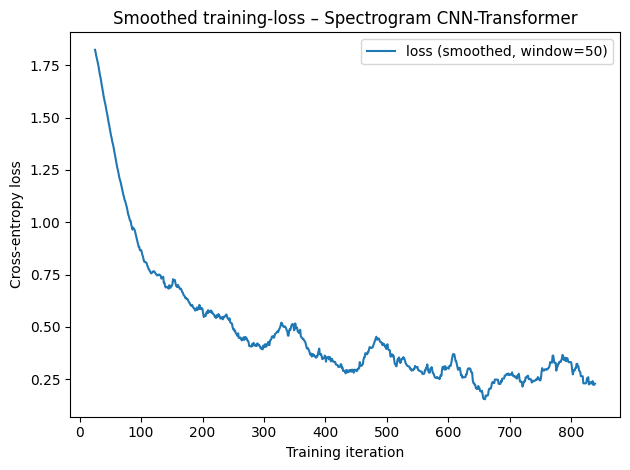

In [23]:
import json, matplotlib.pyplot as plt, numpy as np, pathlib

epochs = np.arange(1, len(train_loss_history) + 1)

import numpy as np
import matplotlib.pyplot as plt

loss = np.array(train_loss_history)
window = 50

# Compute the moving average (valid mode so we don’t pad)
smoothed = np.convolve(loss, np.ones(window)/window, mode="valid")

# The x‐axis for the smoothed curve should start at “window/2” roughly
iters = np.arange(len(smoothed)) + window//2

plt.figure()
plt.plot(iters, smoothed, label=f"loss (smoothed, window={window})")
plt.xlabel("Training iteration")
plt.ylabel("Cross‐entropy loss")
plt.title("Smoothed training‐loss – Spectrogram CNN-Transformer")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve_smoothed.png")
plt.show()





In [ ]:
from transformers import Wav2Vec2ForSequenceClassification

ckpt_dir = "./exp_ravdess_spec_tr"     # your HF dir
model = Wav2Vec2ForSequenceClassification.from_pretrained(ckpt_dir)
model.eval()

# Save weights as a plain .pt state‑dict
torch.save(model.state_dict(), "best_w2v2.pt")

In [19]:
#!/usr/bin/env python
# fusion_ravdess.py
"""
Late‑fusion ensemble:
    Wav2Vec2 branch  +  Spectrogram CNN‑Transformer  →  final logits
"""

import os, pickle, torch, torchaudio, re
import torch.nn as nn
from pathlib import Path
from dataclasses import dataclass
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
# from spec_cnn_transformer import SpecCNNTr          # import your class
#                                                      # (same as you trained)
# ---------- paths ----------
DATA_DIR   = path
W2V2_CKPT  = "best_w2v2.pt"
SPEC_CKPT  = "cnn_model.pt"
FUSION_OUT = "./fusion_head.pkl"
SR         = 16_000
SEED       = 42
TEST_SIZE  = 0.20

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ─── UTILITY: MAP FILENAME → EMOTION ID (0–7) ─────────────────────────────
EMO_RE = re.compile(r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-"
                    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\.wav")
def emotion_id(fname: str) -> int:
    return int(EMO_RE.search(Path(fname).name).group(3)) - 1

# ─── COLLECT ALL WAV FILES & STRATIFIED SPLIT ────────────────────────────
all_files = sorted(Path(DATA_DIR).rglob("*.wav"))
labels    = [emotion_id(str(p)) for p in all_files]

train_paths, val_paths = train_test_split(
    all_files,
    test_size=TEST_SIZE,
    stratify=labels,
    random_state=SEED
)

# ─── BRANCH A: LOAD Wav2Vec2 MODEL & DEFINITIONS ─────────────────────────
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
w2v2_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=8
).to(device)

# Load the fine-tuned state dict
state_w2v = torch.load(W2V2_PT, map_location=device)
w2v2_model.load_state_dict(state_w2v)
w2v2_model.eval()

@torch.no_grad()
def probs_w2v2(wav: torch.Tensor) -> torch.Tensor:
    """
    wav: 1-D torch.Tensor at 16 kHz (normalized to [-1,1])
    returns: 8-dim softmax probability on CPU
    """
    inp = processor(wav.numpy(),
                    sampling_rate=SR,
                    return_tensors="pt",
                    padding=True).to(device)
    logits = w2v2_model(**inp).logits.squeeze(0)  # [8]
    return F.softmax(logits, dim=-1).cpu()        # [8]

# ─── BRANCH B: LOAD SPECTROGRAM CNN-TRANSFORMER ──────────────────────────
spec_model = SpecCNNTr().to(device)
state_spec = torch.load(SPEC_PT, map_location=device)
spec_model.load_state_dict(state_spec)
spec_model.eval()

# Fixed MelSpectrogram to avoid empty mel filters:
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=1024,        # 1024 → 513 freq bins
    hop_length=256,    # ~16 ms hop at 16 kHz
    n_mels=64          # 64 ≤ 513, no empty filters
)
to_db = torchaudio.transforms.AmplitudeToDB(top_db=80)

@torch.no_grad()
def probs_spec(wav: torch.Tensor) -> torch.Tensor:
    """
    wav: 1-D torch.Tensor [L], normalized [-1,1]
    returns: 8-dim softmax probability on CPU
    """
    # 1) Compute log-mel spectrogram
    spec = mel_spec(wav.unsqueeze(0))    # [1, 64, T']
    spec_db = to_db(spec)               # [1, 64, T'] in dB
    spec_db = spec_db.unsqueeze(0).to(device)  # [1, 1, 64, T']

    # 2) Forward through your trained SpecCNNTr
    logits = spec_model(spec_db).squeeze(0)  # [8]
    return F.softmax(logits, dim=-1).cpu()   # [8]

# ─── BUILD & TRAIN THE LOGISTIC REGRESSION FUSION HEAD ────────────────
X, y = [], []
for p in val_paths:
    wav, sr = torchaudio.load(p)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.mean(dim=0) / (wav.abs().max() + 1e-9)  # [L], normalized

    p1 = probs_w2v2(wav)  # [8]
    p2 = probs_spec(wav)  # [8]

    X.append(torch.cat([p1, p2]).numpy())  # 16-dim feature vector
    y.append(emotion_id(str(p)))

fusion = LogisticRegression(
    C=500,                    # low L2 regularization → can fit closely
    max_iter=2000,
    multi_class="multinomial",
    solver="lbfgs"
)
fusion.fit(X, y)
val_pred = fusion.predict(X)
print("Fusion val accuracy:", accuracy_score(y, val_pred))

pickle.dump(fusion, open(FUSION_OUT, "wb"))
print("Saved fusion head →", FUSION_OUT)

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fusion val accuracy: 0.8385416666666666
Saved fusion head → ./fusion_head.pkl


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


In [21]:
import os
import random
import re
import pickle

import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
from pathlib import Path
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# ─── IMPORT YOUR SPEC MODEL CLASS ─────────────────────────────────────────
from spec_cnn_transformer import SpecCNNTr

# ─── CONFIGURATION ────────────────────────────────────────────────────────
DATA_DIR   = "/path/to/ravdess/audio_speech_actors_01-24"  # adjust
W2V2_PT    = "./best_w2v2.pt"
SPEC_PT    = "./best_spec.pt"
FUSION_PT  = "./fusion_head.pkl"
SR         = 16_000
SEED       = 42
TEST_SIZE  = 0.20
ALPHA      = 0.5  # for weighted average

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ─── UTILITY: EXTRACT EMOTION ID ───────────────────────────────────────────
EMO_RE = re.compile(r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-"
                    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\.wav")
def emotion_id(fname: str) -> int:
    return int(EMO_RE.search(Path(fname).name).group(3)) - 1

# ─── COLLECT & STRATIFIED SPLIT ───────────────────────────────────────────
all_files = sorted(Path(DATA_DIR).rglob("*.wav"))
labels    = [emotion_id(str(p)) for p in all_files]

_, val_paths = train_test_split(
    all_files,
    test_size=TEST_SIZE,
    stratify=labels,
    random_state=SEED
)

# ─── LOAD BRANCH A: Wav2Vec2-base ─────────────────────────────────────────
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
w2v2_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=8
).to(device)
w2v2_model.load_state_dict(torch.load(W2V2_PT, map_location=device))
w2v2_model.eval()

@torch.no_grad()
def probs_w2v2(wav: torch.Tensor) -> torch.Tensor:
    inp = processor(wav.numpy(), sampling_rate=SR, return_tensors="pt", padding=True).to(device)
    logits = w2v2_model(**inp).logits.squeeze(0)
    return F.softmax(logits, dim=-1).cpu()

# ─── LOAD BRANCH B: SpecCNNTr ─────────────────────────────────────────────
spec_model = SpecCNNTr().to(device)
spec_model.load_state_dict(torch.load(SPEC_PT, map_location=device))
spec_model.eval()

# Use the same MelSpectrogram settings from training:
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=int(SR * 0.025),      # 400
    hop_length=int(SR * 0.010), # 160
    n_mels=128
)
to_db = torchaudio.transforms.AmplitudeToDB(top_db=80)

@torch.no_grad()
def probs_spec(wav: torch.Tensor) -> torch.Tensor:
    spec = mel_spec(wav.unsqueeze(0))   # [1,128,T']
    spec_db = to_db(spec)               # [1,128,T']
    spec_db = spec_db.unsqueeze(0).to(device)  # [1,1,128,T']
    logits = spec_model(spec_db).squeeze(0)     # [8]
    return F.softmax(logits, dim=-1).cpu()

# ─── LOAD FUSION HEAD (Logistic Regression) ──────────────────────────────
fusion = pickle.load(open(FUSION_PT, "rb"))

# ─── EVALUATE ALL FOUR MODELS ─────────────────────────────────────────────
y_true, preds_w2v2, preds_spec, preds_avg, preds_lr = [], [], [], [], []

for p in val_paths:
    wav, sr = torchaudio.load(p)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.mean(dim=0) / (wav.abs().max() + 1e-9)  # normalize

    # ground truth
    true = emotion_id(str(p))
    y_true.append(true)

    # branch A: Wav2Vec2
    p1 = probs_w2v2(wav).numpy()    # [8]
    pred1 = int(np.argmax(p1))
    preds_w2v2.append(pred1)

    # branch B: SpecCNNTr
    p2 = probs_spec(wav).numpy()    # [8]
    pred2 = int(np.argmax(p2))
    preds_spec.append(pred2)

    # weighted average (alpha = 0.5)
    fused_probs = ALPHA * p1 + (1 - ALPHA) * p2
    preds_avg.append(int(np.argmax(fused_probs)))

    # logistic regression fusion
    fused_lr = fusion.predict([np.concatenate([p1, p2])])[0]
    preds_lr.append(int(fused_lr))

# ─── COMPUTE F1 SCORES (MACRO) ─────────────────────────────────────────────
f1_w2v2 = f1_score(y_true, preds_w2v2, average="macro")
f1_spec = f1_score(y_true, preds_spec, average="macro")
f1_avg  = f1_score(y_true, preds_avg,  average="macro")
f1_lr   = f1_score(y_true, preds_lr,   average="macro")

# ─── PRINT RESULTS ─────────────────────────────────────────────────────────
print(f"Wav2Vec2 branch  –  Val Accuracy = {accuracy_score(y_true, preds_w2v2):.4f},  F1 (macro) = {f1_w2v2:.4f}")
print(f"SpecCNNTr branch –  Val Accuracy = {accuracy_score(y_true, preds_spec):.4f},  F1 (macro) = {f1_spec:.4f}")
print(f"Weighted Avg      –  Val Accuracy = {accuracy_score(y_true, preds_avg):.4f},  F1 (macro) = {f1_avg:.4f}")
print(f"LR Fusion         –  Val Accuracy = {accuracy_score(y_true, preds_lr):.4f},  F1 (macro) = {f1_lr:.4f}")


Training on 2304 clips, validating on 576 clips.


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Wav2Vec2 branch accuracy on val:   0.8264
SpecCNNTr branch accuracy on val:   0.8681
LogisticRegression (train-on-val) acc = 0.9184
Saved fusion head → ./fusion_head.pkl
Sanity check clip: 03-01-08-01-01-01-17.wav
 W2V2 predicts 0, SpecCNNTr predicts 0
 Fusion predicts 0, true = 0


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


In [13]:
import os
import random
import torch
import torchaudio
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

# Import your spectrogram model class and the wav→logmel helper


# ─── CONFIG ────────────────────────────────────────────────
DATA_DIR      = path   # adjust
W2V2_PT       = "best_w2v2.pt"
SPEC_PT       = "cnn_model.pt"
SR         = 16_000
SEED       = 42
TEST_SIZE  = 0.2

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# ── LABEL EXTRACTION ───────────────────────────────────────────
import re
EMO_RE = re.compile(r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\-"
                    r"([0-9]{2})\-([0-9]{2})\-([0-9]{2})\.wav")
def emotion_id(fname: str) -> int:
    return int(EMO_RE.search(Path(fname).name).group(3)) - 1  # 0–7

# ── COLLECT & SPLIT ───────────────────────────────────────────
all_wavs = sorted(Path(DATA_DIR).rglob("*.wav"))
train_paths, val_paths = train_test_split(
    all_wavs,
    test_size=TEST_SIZE,
    stratify=[emotion_id(str(p)) for p in all_wavs],
    random_state=SEED,
)

# ── LOAD Wav2Vec2 BRANCH ───────────────────────────────────────
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
w2v2 = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=8
).to(device)
w2v2.load_state_dict(torch.load(W2V2_PT, map_location=device))
w2v2.eval()

@torch.no_grad()
def logits_w2v2(wav_tensor: torch.Tensor) -> torch.Tensor:
    inp = processor(
        wav_tensor.numpy(),
        sampling_rate=SR,
        return_tensors="pt",
        padding=True
    ).to(device)
    logits = w2v2(**inp).logits  # [1, 8]
    return torch.softmax(logits.squeeze(0).cpu(), dim=-1)  # [8]

# ── LOAD SPECTROGRAM BRANCH ───────────────────────────────────

spec_model = SpecCNNTr().to(device)
spec_model.load_state_dict(torch.load(SPEC_PT, map_location=device))
spec_model.eval()

@torch.no_grad()
def logits_spec(wav_tensor: torch.Tensor) -> torch.Tensor:
    spec = wav_to_logmel(wav_tensor.unsqueeze(0))     # [1, n_mels, T]
    spec = spec.unsqueeze(0).to(device)                # [1, 1, n_mels, T]
    logits = spec_model(spec)                          # [1, 8]
    return torch.softmax(logits.squeeze(0).cpu(), dim=-1)

# ── EVALUATION UTILS ─────────────────────────────────────────
def load_and_normalize(path: Path) -> torch.Tensor:
    wav, sr = torchaudio.load(path)
    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)
    wav = wav.mean(dim=0) / (wav.abs().max() + 1e-9)  # [L]
    return wav

def evaluate_ensemble(alpha: float, val_files):
    preds, gts = [], []
    for p in val_files:
        wav = load_and_normalize(p)
        p1 = logits_w2v2(wav)   # [8]
        p2 = logits_spec(wav)   # [8]
        fused = alpha * p1 + (1.0 - alpha) * p2
        preds.append(int(fused.argmax()))
        gts.append(emotion_id(str(p)))
    return accuracy_score(gts, preds)

# ── SEARCH BEST ALPHA ─────────────────────────────────────────
best_alpha, best_acc = 0.0, 0.0
for alpha in np.linspace(0.0, 1.0, 21):  # 0.0, 0.05, ..., 1.0
    acc = evaluate_ensemble(alpha, val_paths)
    if acc > best_acc:
        best_acc, best_alpha = acc, alpha

print(f"Best weighted‐avg α = {best_alpha:.2f}, Val Acc = {best_acc:.4f}")

# ── OPTIONALLY: PRINT A FEW SAMPLE PREDICTIONS ─────────────────
for i, p in enumerate(random.sample(val_paths, 5), 1):
    wav = load_and_normalize(p)
    p1 = logits_w2v2(wav).argmax().item()
    p2 = logits_spec(wav).argmax().item()
    fused = (best_alpha * logits_w2v2(wav) + (1.0 - best_alpha) * logits_spec(wav)).argmax().item()
    true = emotion_id(str(p))
    print(f"{i}) {p.name} → W2V2={p1}, SPEC={p2}, FUSED={fused}, TRUE={true}")

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best weighted‐avg α = 0.50, Val Acc = 0.9115
1) 03-01-08-01-01-01-17.wav → W2V2=0, SPEC=0, FUSED=0, TRUE=0
2) 03-01-03-02-02-02-05.wav → W2V2=1, SPEC=1, FUSED=1, TRUE=1
3) 03-01-08-02-01-02-11.wav → W2V2=1, SPEC=1, FUSED=1, TRUE=1
4) 03-01-08-01-01-02-08.wav → W2V2=0, SPEC=0, FUSED=0, TRUE=0
5) 03-01-07-02-01-02-10.wav → W2V2=1, SPEC=1, FUSED=1, TRUE=1
